<h1 style="color:SteelBlue; font-size:200%">Сравнительный анализ доходности тарифов сотовой связи </h1>

Задача: на небольшой выборке клиентов сравнить доходность двух тарифов сотовой связи. Нужно проанализировать поведение клиентов и определить, какой тариф приносит компании больший доход. В распоряжении - данные о действиях 500 пользователей.

Данные разделены на несколько наборов:
- *users* - информация о пользователях
- *calls* - информация о звонках
- *messages* - информация о сообщениях
- *internet* - информация об интернет-сессиях
- *tariffs* - информация о тарифах

План:
- разведочный анализ данных
    - просмотр датасетов и общей информации, выявление проблем
    - анализ: какие города, возрасты, тарифные планы представлены, есть ли выбросы/аномалии в данных


- очистка и дополнение данных, исправление ошибок
    - очистка дублей
    - замена типов
    - анализ/заполнение пропусков
    - исправление ошибок


- подготовка данных для анализа
    - расчёт недостающих значений
    - группировка по месяцам и пользователям: суммарное время звонков, число сообщений, объём интернет траффика для каждого пользователя по месяцам
    - объединение данных в общую таблицу
    - расчёт превышения лимитов по тарифу для каждого месяца и клиента
    - расчёт доплат и общей суммы прибыли, полученный в каждом месяце с каждого клиента 


- анализ данных
    - построение и анализ графиков
    - сравнение тарифов


- общий вывод

Анализ будет основан на сравнении двух выборок (одна - для тарифа смарт, другая - для тарифа ультра). Значение каждого элемента выборки - месячные затраты клиента на услуги сотовой связи, а также - число минут разговора, объём траффика и число смс. Статистический метод сравнения среднегодовых выручек по разным тарифам будет зависет от характера распределия, которое покажут данные. Если будет близкое к нормальному закону, можно использовать t-тест. Если нет - можно воспользоваться перестановочным тестом, либо непараметрическим критерием (например, критерием Манна-Уитни)

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
palette = {'smart':'c', 'ultra':'r'}
#pd.options.mode.chained_assignment = None  # default='warn'

<h1 style="color:SteelBlue"> 1. Разведочный анализ данных</h1>

In [4]:
link='C:/Users/Affernus/JupiterNotebooks/datasets/megaline/'
users_df = pd.read_csv(link+'users.csv')
calls_df = pd.read_csv(link+'calls.csv')
sms_df = pd.read_csv(link+'messages.csv')
inet_df = pd.read_csv(link+'internet.csv')
tariffs_df = pd.read_csv(link+'tariffs.csv')

<h2 style="color:DodgerBlue">1.1 Общая информация</h2>

In [5]:
display('Тарифы:', tariffs_df)

'Тарифы:'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
display('Пользователи:', users_df.head())
display('Звонки:', calls_df.head())
display('СМС:', sms_df.head())
display('Траффик:', inet_df.head())

'Пользователи:'

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


'Звонки:'

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


'СМС:'

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


'Траффик:'

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
print('\nПользователи:\n')
users_df.info()
print('\nЗвонки:\n')
calls_df.info()
print('\nСМС:\n')
sms_df.info()
print('\nТраффик:\n')
inet_df.info()


Пользователи:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Звонки:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB



In [8]:
users_df.loc[~users_df.loc[:,'churn_date'].isna(), :].head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


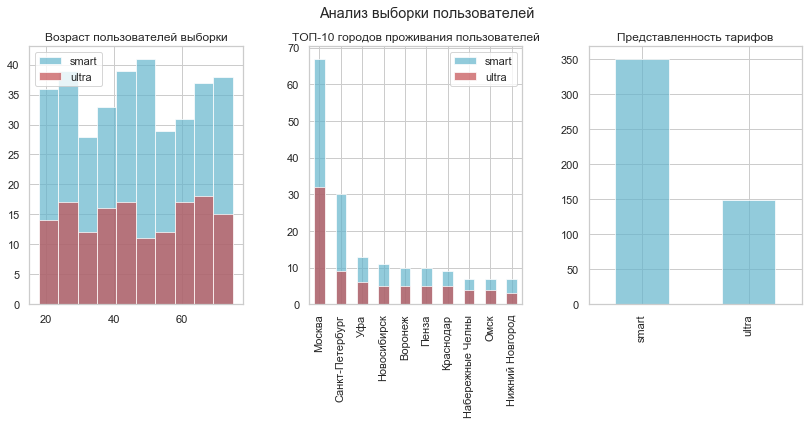

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
ax1, ax2, ax3 = ax.flatten()
ax1.set_title('Возраст пользователей выборки')
ax2.set_title('ТОП-10 городов проживания пользователей')
ax3.set_title('Представленность тарифов')
for tariff in palette.keys():
    users_df.loc[users_df.loc[:, 'tariff'] == tariff, 'age'].hist(ax=ax1, 
                                                                  color=palette[tariff], 
                                                                  label=tariff, 
                                                                  alpha=0.7)
    users_df.loc[users_df.loc[:, 'tariff'] == tariff, 'city'].value_counts().head(10).plot(ax=ax2, 
                                                                                           kind='bar', 
                                                                                           alpha=0.7,
                                                                                           label=tariff,
                                                                                           color=palette[tariff])

users_df['tariff'].value_counts().plot(ax=ax3,kind='bar', alpha=0.7, color='c')
ax1.legend()
ax2.legend()
plt.suptitle('Анализ выборки пользователей')
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

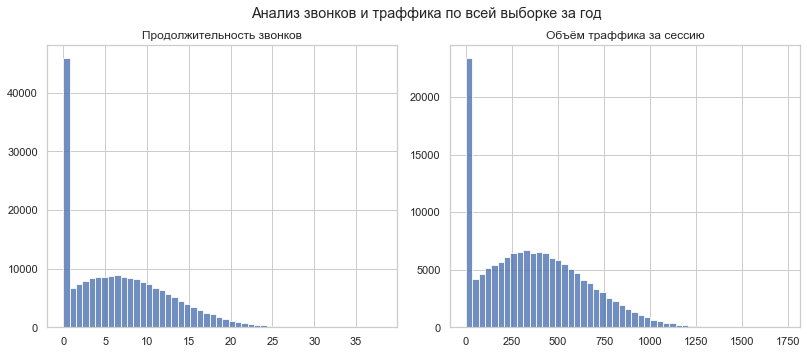

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].set_title('Продолжительность звонков')
ax[1].set_title('Объём траффика за сессию')
calls_df['duration'].hist(ax=ax[0], bins=50, alpha=0.8)
inet_df['mb_used'].hist(ax=ax[1], bins=50, alpha=0.8)
plt.suptitle('Анализ звонков и траффика по всей выборке за год')
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

In [11]:
print('Число пользователей в выборке:', users_df['user_id'].unique().size)

Число пользователей в выборке: 500


<h1 style="color:SteelBlue"> Результаты разведочного анализа</h1>

Выборка равномерно представлена клиентами всех возрастов. В тарифе ultra Москва представлена в 4 раза лучше городов-соседей по топ 10 (более 30 пользователей и более 20% выборки), в тарифе smart - более чем в 2 раза лучше Петербурга и в несколько раз лучше прочих. Заметно, что в СПб тариф ultra в процентном отношении к smart представлен хуже, чем у соседей по топ-10.

Тариф смарт представлен 350 пользователями, ультра - 150. В выборке 500 уникальных значений пользователей, значит, никто из них не пользовался обоими тарифами.

В объёме траффика и продолжительности звонков много нулевых значений. Видимо, пропущенные/сброшенные звонки и технические сессии. 

Пропуски только для признака *churn_date*. Пропуски в *churn_date* означают, что большинство клиентов пользовались тарифом на момент выгрузки базы. Поскольку плата за тариф берётся помесячно, то нужно получить для каждого клиента сатистику выручки по месяцам. Затем можно рассчитать суммарную и среднюю выручку для каждого клиента, а также её вариабельность. Нужно рассчитать, сколько месяцев каждый клиент пользовался тарифом. Для этого пропуски в churn_date надо заполнить датой выгрузки базы.

<h1 style="color:SteelBlue">2. Очистка и дополнение данных, исправление ошибок</h1>

<h2 style="color:DodgerBlue">2.1 Изменение типов данных и поиск полных дублей</h2>

Во всех датасетах нужно привести дату и время к формату datetime. Сделаю это и проверю число дублей в наборах данных.

In [12]:
users_df.loc[:, 'churn_date'] = pd.to_datetime(users_df['churn_date'], format='%Y-%m-%d')
users_df.loc[:, 'reg_date'] = pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')
calls_df.loc[:, 'call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')
sms_df.loc[:, 'message_date'] = pd.to_datetime(sms_df['message_date'], format='%Y-%m-%d')
inet_df.loc[:, 'session_date'] = pd.to_datetime(inet_df['session_date'], format='%Y-%m-%d')

In [13]:
print('Число полных дублей в датасетах')
display(
    users_df.duplicated().sum(),
    calls_df.duplicated().sum(),
    sms_df.duplicated().sum(),
    inet_df.duplicated().sum()
)

Число полных дублей в датасетах


0

0

0

0

<h2 style="color:DodgerBlue">2.2 Заполнение пропусков, расчёт дополнительных и удаление ненужных признаков</h2>

Нужно выяснить дату выгрузки базы. Определю по датам последних звонков

In [14]:
calls_df['call_date'].describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

В базе данные за полный 2018 год, c 2018-01-01 по 2018-12-31. Большинство клиентов пользовались тарифом на момент выгрузки базы. Чтобы в дальнейшем рассчитать число полных месяцев, в течение которых клиент пользовался тарифом, заполню пропуски в *churn_date* датой 2018-12-31

In [15]:
users_df.loc[:, 'churn_date'].fillna(np.datetime64('2018-12-31'), inplace=True)

In [16]:
users_df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Кроме этого, для анализа понадобятся: 
- число полных дней и месяцев пользования тарифом (N_days_usage, N_months_usage)
- месяц и день начала пользования тарифом (reg_month, reg_day)
- месяц прекращения пользования (churn_month, churn_day)
- месяц совершения действия (звонок, смс, интернет-сессия: call_month, message_month, session_month)
- округлённое в большую сторону время разговора и число мегабайт траффика (duration_ceil, mb_used_ceil)


Досчитаю эти признаки в датасет пользователей.

In [17]:
users_df.loc[:, 'N_months_usage'] = (
    (users_df['churn_date'] - users_df['reg_date']) 
    / np.timedelta64(1, 'M')).astype('int')
users_df.loc[:, 'N_days_usage'] = (
    (users_df['churn_date'] - users_df['reg_date']) 
    / np.timedelta64(1, 'D')).astype('int')
users_df.loc[:, 'reg_month'] = pd.DatetimeIndex(users_df['reg_date']).month
users_df.loc[:, 'reg_day'] = pd.DatetimeIndex(users_df['reg_date']).day
users_df.loc[:, 'churn_month'] = pd.DatetimeIndex(users_df['churn_date']).month
users_df.loc[:, 'churn_day'] = pd.DatetimeIndex(users_df['churn_date']).day

calls_df.loc[:, 'calendar_month'] = pd.DatetimeIndex(calls_df['call_date']).month
calls_df.loc[:, 'duration_ceil'] = calls_df['duration'].apply(np.ceil).astype(int)

inet_df.loc[:, 'calendar_month'] = pd.DatetimeIndex(inet_df.loc[:, 'session_date']).month
inet_df.loc[:, 'mb_used_ceil'] = inet_df['mb_used'].apply(np.ceil).astype(int)

sms_df.loc[:, 'calendar_month'] = pd.DatetimeIndex(sms_df.loc[:, 'message_date']).month

Столбцы с именем и фамилией, идентификаторами события (id: 1000_0, 1000_1 и т.д.) и стобец "Unnamed: 0" удалю. Они не нужны для решения задачи.

In [18]:
users_df.drop(columns=['first_name', 'last_name'], inplace=True)
inet_df.drop(columns=['Unnamed: 0', 'id'], inplace=True)
calls_df.drop('id', axis=1, inplace=True)
sms_df.drop('id', axis=1, inplace=True)

In [19]:
display('Пользователи:', users_df.head())
display('Звонки:', calls_df.head())
display('СМС:', sms_df.head())
display('Траффик:', inet_df.head())

'Пользователи:'

,user_id,age,churn_date,city,reg_date,tariff,N_months_usage,N_days_usage,reg_month,reg_day,churn_month,churn_day
0,1000,52,2018-12-31,Краснодар,2018-05-25,ultra,7,220,5,25,12,31
1,1001,41,2018-12-31,Москва,2018-11-01,smart,1,60,11,1,12,31
2,1002,59,2018-12-31,Стерлитамак,2018-06-17,smart,6,197,6,17,12,31
3,1003,23,2018-12-31,Москва,2018-08-17,ultra,4,136,8,17,12,31
4,1004,68,2018-12-31,Новокузнецк,2018-05-14,ultra,7,231,5,14,12,31


'Звонки:'

,call_date,duration,user_id,calendar_month,duration_ceil
0,2018-07-25,0.00,1000,7,0
1,2018-08-17,0.00,1000,8,0
2,2018-06-11,2.85,1000,6,3
3,2018-09-21,13.80,1000,9,14
4,2018-12-15,5.18,1000,12,6


'СМС:'

,message_date,user_id,calendar_month
0,2018-06-27,1000,6
1,2018-10-08,1000,10
2,2018-08-04,1000,8
3,2018-06-16,1000,6
4,2018-12-05,1000,12


'Траффик:'

,mb_used,session_date,user_id,calendar_month,mb_used_ceil
0,112.95,2018-11-25,1000,11,113
1,1052.81,2018-09-07,1000,9,1053
2,1197.26,2018-06-25,1000,6,1198
3,550.27,2018-08-22,1000,8,551
4,302.56,2018-09-24,1000,9,303


<h2 style="color:DodgerBlue">2.3 Анализ выборки, исправление ошибок и очистка данных</h2>

На основании рассчитанных признаков оценим выборку клиентов.

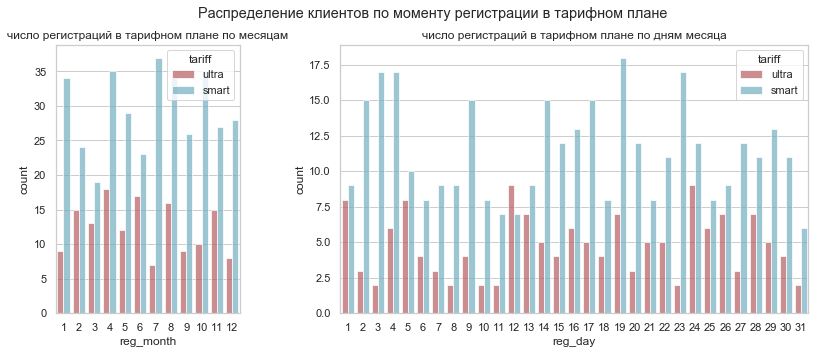

In [20]:
plt.figure(figsize=(12,5))
plt.suptitle('Распределение клиентов по моменту регистрации в тарифном плане')
gridsize = (1, 3)
#оси; 1 - начинать с 0-0, занять 1 строку и 1 столбец; 2-начинать с 0-1, занять 1 строку и 2 столбца
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 1), colspan=2, rowspan=1)

ax1.set_title('число регистраций в тарифном плане по месяцам')
ax2.set_title('число регистраций в тарифном плане по дням месяца')
sns.countplot(ax=ax1, x='reg_month', hue='tariff', data=users_df, palette=palette, alpha=0.7)
sns.countplot(ax=ax2, x='reg_day', hue='tariff', data=users_df, palette=palette, alpha=0.7)
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

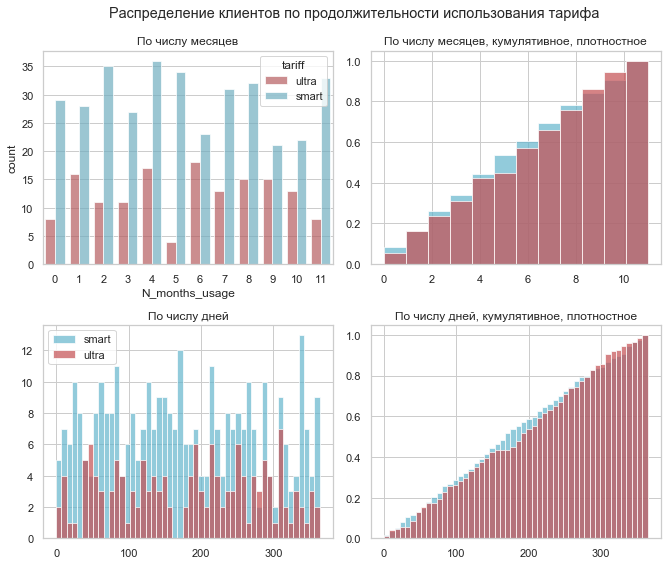

In [21]:
plt.figure(figsize=(10,8))
plt.suptitle('Распределение клиентов по продолжительности использования тарифа')

plt.subplot(221)
plt.title('По числу месяцев')
sns.countplot(x='N_months_usage', hue='tariff', data=users_df, palette=palette, alpha=0.7)

plt.subplot(222)
plt.title('По числу месяцев, кумулятивное, плотностное')
for tariff in palette.keys():
    users_df.loc[users_df.loc[:, 'tariff'] == tariff, 'N_months_usage'].hist(bins=12, label=tariff, cumulative=1, 
                                                                             density=True, color=palette[tariff],
                                                                             alpha=0.7)
    

plt.subplot(223)
plt.title('По числу дней')
for tariff in palette.keys():
    users_df.loc[users_df.loc[:, 'tariff'] == tariff, 'N_days_usage'].hist(bins=50, label=tariff, color=palette[tariff],
                                                                           alpha=0.7)
plt.legend()

plt.subplot(224)
plt.title('По числу дней, кумулятивное, плотностное')
for tariff in palette.keys():
    users_df.loc[users_df.loc[:, 'tariff'] == tariff, 'N_days_usage'].hist(bins=50, label=tariff, cumulative=1,
                                                                           density=True, color=palette[tariff],
                                                                           alpha=0.7)

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

Сильных смещений не видно, есть варибельность от месяца к месяцу и от недели к неделе, но в целом, похоже, выборка сделана действительно случайно.

In [22]:
print('Пользовались тарифом меньше полного месяца:',
     users_df[users_df['N_months_usage'] == 0]['N_months_usage'].count(), 'клиентов')
print('Пользовались тарифом меньше 28 дней:',
     users_df[users_df['N_days_usage'] < 28]['N_days_usage'].count(), 'клиента')

Пользовались тарифом меньше полного месяца: 37 клиентов
Пользовались тарифом меньше 28 дней: 32 клиента


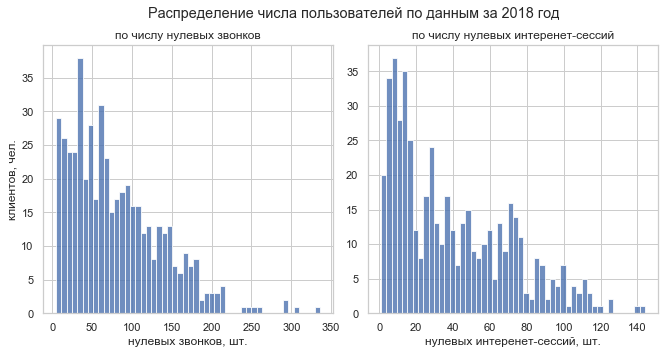

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.suptitle('Распределение числа пользователей по данным за 2018 год')
ax[0].set_title('по числу нулевых звонков')
ax[0].set_xlabel('нулевых звонков, шт.')
ax[0].set_ylabel('клиентов, чел.')

ax[1].set_title('по числу нулевых интеренет-сессий')
ax[1].set_xlabel('нулевых интеренет-сессий, шт.')

calls_df.loc[calls_df.loc[:, 'duration'] == 0, :].groupby('user_id')['user_id'].count().hist(ax=ax[0], bins=50, alpha=0.8)
inet_df.loc[inet_df.loc[:, 'mb_used'] == 0, :].groupby('user_id')['user_id'].count().hist(ax=ax[1], bins=50, alpha=0.8)

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

В данных есть много звонков нулевой продолжительности и интернет сессий с траффиком 0 мегабайт. Они не вносят никакого вклада в прибыль и, скорее всего, являются пропущенными/сброшенными звонками и техническими пакетами данных. На гистограммах сильных аномалий не наблюдается: у большинства пользователей немного и того и другого. Выбросов нет. Исключу нулевые звонки и интеренет сессии из исследования, чтобы не занимать память.

In [24]:
calls_df.drop(calls_df.loc[calls_df.loc[:, 'duration'] == 0, :].index, inplace=True)
inet_df.drop(inet_df.loc[inet_df.loc[:, 'mb_used'] == 0, :].index, inplace=True)

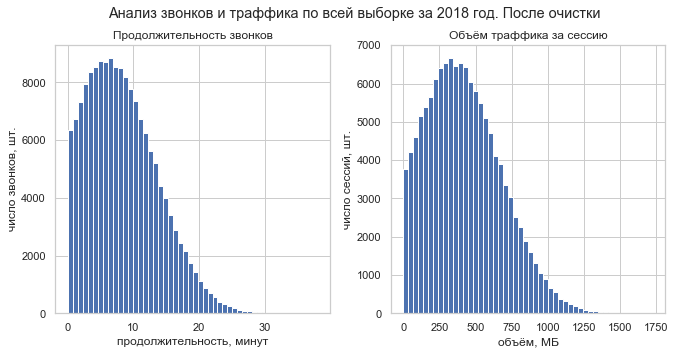

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_title('Продолжительность звонков')
ax[0].set_xlabel('продолжительность, минут')
ax[0].set_ylabel('число звонков, шт.')

ax[1].set_title('Объём траффика за сессию')
ax[1].set_xlabel('объём, МБ')
ax[1].set_ylabel('число сессий, шт.')
calls_df['duration'].hist(ax=ax[0], bins=50)
inet_df['mb_used'].hist(ax=ax[1], bins=50)
plt.suptitle('Анализ звонков и траффика по всей выборке за 2018 год. После очистки')
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

<h1 style="color:SteelBlue">Итоги очистки данных</h1>

Во всех датасетах дату и время перевёл в формат datetime. Проверил на полные дубли, их нет. Для того, чтобы рассчитать, сколько полных месяцев клиент пользовался тарифом, заполнил пропуски в *churn_date* датой 2018-12-31 (пропущены значения для клиентов, которые на момент 31-12-2018 пользовались тарифом). Других пропусков в данных нет. 

Добавил в данные о пользователях некоторую техническую информацию

- число полных дней и месяцев пользования тарифом (N_days_usage, N_months_usage)
- месяц и день начала пользования тарифом (reg_month, reg_day)
- месяц и день прекращения пользования (churn_month, churn_day)
- месяц совершения действия (звонок, смс, интернет-сессия: call_month, message_month, session_month)
- округлённое в большую сторону время разговора и число мегабайт траффика (duration_ceil, mb_used_ceil)

На основе этой информации проанализировал выборку клиентов. Целью был поиск признаков неслучайности её формирования: перекос в сторону каких-либо возрастов, месяцев, чисел и т.д. Оказалось, что явных перекосов нет. Есть определённая вариабельность, но в целом выборка действительно похожа на случайную: представлены все возрасты, месяцы и дни регистрации, продолжительности пользования тарифом.  


Проанализировал на выбросы продолжительность разговоров, объём интернет траффика. Выбросов не обнаружил, но выявил множество "нулевых" звонков и сессий. Счёл их пропущенными звонками и техническими пакетами. Проверил их распределение по пользователям, аномалий не обнаружил. Из анализа исключил нулевые звонки и интеренет сессии. Вид распределений улучшился после очистки.

<h1 style="color:SteelBlue">3. Подготовка таблиц для анализа данных</h1>

<h2 style="color:DodgerBlue">3.1 Выбор методики анализа</h2>

Поскольку непонятно, как считать выручку с неполного месяца пользования тарифом, в расчёт возьму только полные и почти полные месяцы. За почти полные приму те, в которых тарифом пользовались не менее 90% дней (это примерно число дней в месяце минус 3 дня).


Большинство пользователей пользовались тарифами на момент выгрузки базы (31 декабря 2018). Если считать статистику по месяцам, начиная с даты их регистрации, то для большинства декабрь будет потерян, т.к. не будет являться полным месяцем. Удобнее считать статистику по календарным месяцам и отбросить (если там мало дней пользования) только месяц регистрации. Поскольку месяцы регистрации разные, представительность данных по месяцам останется в норме.

In [26]:
print('Отказались от услуг до 31 декабря:',
    users_df[users_df['churn_date'] != '2018-12-31']['churn_date'].count(), 'клиентов')
print('Среди них меньше месяца тарифом пользовались',
    users_df[(users_df['churn_date'] != '2018-12-31') & 
             (users_df['N_months_usage'] < 1)
            ]['churn_date'].count(), 'клиента')

Отказались от услуг до 31 декабря: 38 клиентов
Среди них меньше месяца тарифом пользовались 3 клиента


Для пользователей, которые отказались от использования тарифа до 31 декабря, потеряются дополнительно к месяцам регистрации месяцы отказа, если из них прошло менее 90% дней. Например, если клиент зарегистрировался 15 марта и отказался 15 мая, то он пользовался тарифом 2 полных месяца. Но методика анализа по календарным месяцам учтёт только апрель. Будет потерян 1 полный месяц. С учётом клиентов, которые и так пользовались тарифом меньше месяца, максимум будет потеряно 35 месяцев (по месяцу на каждого клиента).

In [27]:
print('Всего полных месяцев пользования тарифом для всей выборки клиентов:', users_df['N_months_usage'].sum())
print(f"""Доля полных месяцев, которые могут быть потеряны из-за методики анализа 
по календарным месяцам: {(35 / 2707):.2%} max""")

Всего полных месяцев пользования тарифом для всей выборки клиентов: 2707
Доля полных месяцев, которые могут быть потеряны из-за методики анализа 
по календарным месяцам: 1.29% max


Максимально возможные потери невелики. При этом у анализа по календарным месяцам, в отличие от анализа по фактически прошедшим с регистрации, больше перспектив. Можно оценить изменения от месяца к месяцу, сравнить предновогодний декабрь и другие месяцы, кварталы и т.д. С учётом этого далее данные буду готовить для анализа по календарным месяцам.

<h2 style="color:DodgerBlue">Результаты выбора методики</h2>

Анализ по календарным месяцам, в отличие от анализа по фактически прошедшим с регистрации, перспективнее. Можно оценить изменения от месяца к месяцу, сравнить предновогодний декабрь и другие месяцы и т.д. Потери данных при этом минимальны. Поэтому данные буду готовить для анализа по календарным месяцам.

<h2 style="color:DodgerBlue">3.2 Подготовка сводной таблицы с данными об услугах по клиентам и месяцам</h2>

На основе датасетов по звонкам, интернет-сессиям и смс составлю сводные таблицы. Сгруппирую и просуммирую по месяцам и id клиентов минуты звонков, мегабайты и число смс. Затем выполню объединение по столбцам месяца и id.

Датасеты с продолжительностью звонков, числом смс и объёмом интеренет траффика:

In [28]:
calls_by_calendar_month = calls_df.pivot_table(index=['user_id', 'calendar_month'], values='duration_ceil', aggfunc='sum')
inet_by_calendar_month = inet_df.pivot_table(index=['user_id', 'calendar_month'], values='mb_used_ceil', aggfunc='sum')
sms_by_calendar_month = sms_df.pivot_table(index=['user_id', 'calendar_month'], values='message_date', aggfunc='count')

In [29]:
display(calls_by_calendar_month.head(), inet_by_calendar_month.head(), sms_by_calendar_month.head())

duration_ceil
user_id calendar_month               
1000    5                         159
        6                         172
        7                         340
        8                         408
        9                         466

mb_used_ceil
user_id calendar_month              
1000    5                       2256
        6                      23257
        7                      14016
        8                      14070
        9                      14581

message_date
user_id calendar_month              
1000    5                         22
        6                         60
        7                         75
        8                         81
        9                         57

In [30]:
calls_by_calendar_month.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3168 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   duration_ceil  3168 non-null   int32
dtypes: int32(1)
memory usage: 25.8 KB


In [31]:
inet_by_calendar_month.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3201 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   mb_used_ceil  3201 non-null   int32
dtypes: int32(1)
memory usage: 26.0 KB


In [32]:
sms_by_calendar_month.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2717 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   message_date  2717 non-null   int64
dtypes: int64(1)
memory usage: 32.8 KB


Объединяю, переименовываю столбцы. У некоторых пользователей в месяце не всегда есть смс, звонки или интернет-сессии, поэтому при слиянии возникнут NaN. Их заполню нулями.

In [33]:
calls_mrg_inet = calls_by_calendar_month.merge(inet_by_calendar_month, on=['calendar_month', 'user_id'], how='outer')
stat_by_calendar_month = calls_mrg_inet.merge(sms_by_calendar_month, 
                                               on=['calendar_month', 'user_id'], 
                                               how='outer').reset_index()
stat_by_calendar_month.fillna(0, inplace=True)

In [34]:
stat_by_calendar_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   calendar_month  3214 non-null   int64  
 1   user_id         3214 non-null   int64  
 2   duration_ceil   3214 non-null   float64
 3   mb_used_ceil    3214 non-null   float64
 4   message_date    3214 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 125.7 KB


Переименую столбцы согласно смыслу содержимого.

<h2 style="color:DodgerBlue">Создана сводная таблица с минутами разговоров, количеством смс и интернет-траффиком по календарным месяцам и клиентам:</h2>

In [35]:
stats_rename_list = {'message_date': 'messages',
                     'duration_ceil':'minutes_used',
                     'mb_used_ceil': 'mb_used'}

stat_by_calendar_month.rename(columns=stats_rename_list, inplace=True)
stat_by_calendar_month.head()

,calendar_month,user_id,minutes_used,mb_used,messages
0,5,1000,159.0,2256.0,22.0
1,6,1000,172.0,23257.0,60.0
2,7,1000,340.0,14016.0,75.0
3,8,1000,408.0,14070.0,81.0
4,9,1000,466.0,14581.0,57.0


In [36]:
stat_by_calendar_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   calendar_month  3214 non-null   int64  
 1   user_id         3214 non-null   int64  
 2   minutes_used    3214 non-null   float64
 3   mb_used         3214 non-null   float64
 4   messages        3214 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 125.7 KB


<h2 style="color:DodgerBlue">3.3 Добавление информации о пользователях, отделение полных месяцев от неполных</h2>

Добавляю информацию о пользователях, сливая с таблицей users_df:

In [37]:
stat_by_calendar_month = stat_by_calendar_month.merge(users_df, on='user_id', how='left')
stat_by_calendar_month.head()

,calendar_month,user_id,minutes_used,mb_used,messages,age,churn_date,city,reg_date,tariff,N_months_usage,N_days_usage,reg_month,reg_day,churn_month,churn_day
0,5,1000,159.0,2256.0,22.0,52,2018-12-31,Краснодар,2018-05-25,ultra,7,220,5,25,12,31
1,6,1000,172.0,23257.0,60.0,52,2018-12-31,Краснодар,2018-05-25,ultra,7,220,5,25,12,31
2,7,1000,340.0,14016.0,75.0,52,2018-12-31,Краснодар,2018-05-25,ultra,7,220,5,25,12,31
3,8,1000,408.0,14070.0,81.0,52,2018-12-31,Краснодар,2018-05-25,ultra,7,220,5,25,12,31
4,9,1000,466.0,14581.0,57.0,52,2018-12-31,Краснодар,2018-05-25,ultra,7,220,5,25,12,31


Создаю флаг-столбец для маркировки полных и неполных месяцев:

In [38]:
def full_month(df, column='calendar_month'):
    k=3
    not_reg_month = ( df['calendar_month'] != df['reg_month'] )
    not_churn_month = ( df['calendar_month'] != df['churn_month'] )
    reg_day_ok = ( df['reg_day'] <= k )
    churn_day_ok = ( df['churn_day'] >= (pd.DatetimeIndex(df.loc[:, 'churn_date']).days_in_month - k) )
    only1_and_days_ok = ( 
        (df['churn_day'] - df['reg_day']) >= (pd.DatetimeIndex(df.loc[:, 'churn_date']).days_in_month - k)
    )
    #полный календарный месяц, если
    #это не месяц регистрации и не месяц ухода или    
    #это месяц регистрации и не месяц ухода и день регистрации - не позднее k-го дня месяца или
    #это месяц ухода и не месяц регистрации и день ухода не ранее, чем за k-дней до конца месяца или   
    #это месяц регистрации и ухода и число дней не менее чем дней в месяце минус k
    
    its_full_calendar_month = ( 
        ( not_reg_month & not_churn_month ) | 
        ( (~not_reg_month) & not_churn_month & reg_day_ok) |
        ( (~not_churn_month) & not_reg_month & churn_day_ok) |
        ( ~not_reg_month & ~not_churn_month & only1_and_days_ok)
    )
    df.loc[:, 'its_full_calendar_month'] = its_full_calendar_month 

In [39]:
full_month(stat_by_calendar_month)

Проверяю работу метода оценки полноты месяца. Всё корректно: для индекса 154 полных месяцев 0, но 30 дней в декабре. Считаю за полный месяц. Для индексов 98 и 99: 11й месяц неполный (регистрация 14 ноября), 12й - полный. Алгоритм помог избежать ненужных потерь.

In [40]:
stat_by_calendar_month[stat_by_calendar_month['N_months_usage'] == 0].head()

,calendar_month,user_id,minutes_used,mb_used,messages,age,churn_date,city,reg_date,tariff,N_months_usage,N_days_usage,reg_month,reg_day,churn_month,churn_day,its_full_calendar_month
62,12,1008,339.0,13236.0,56.0,63,2018-12-31,Челябинск,2018-12-19,smart,0,12,12,19,12,31,False
154,12,1022,267.0,15456.0,10.0,72,2018-12-31,Санкт-Петербург,2018-12-01,smart,0,30,12,1,12,31,True
390,11,1062,405.0,6570.0,14.0,24,2018-12-09,Москва,2018-11-16,smart,0,23,11,16,12,9,False
391,12,1062,290.0,4520.0,12.0,24,2018-12-09,Москва,2018-11-16,smart,0,23,11,16,12,9,False
443,12,1069,349.0,11367.0,56.0,36,2018-12-31,Екатеринбург,2018-12-10,smart,0,21,12,10,12,31,False


In [41]:
stat_by_calendar_month[stat_by_calendar_month['N_months_usage'] == 1].head()

,calendar_month,user_id,minutes_used,mb_used,messages,age,churn_date,city,reg_date,tariff,N_months_usage,N_days_usage,reg_month,reg_day,churn_month,churn_day,its_full_calendar_month
8,11,1001,430.0,18452.0,0.0,41,2018-12-31,Москва,2018-11-01,smart,1,60,11,1,12,31,True
9,12,1001,414.0,14053.0,0.0,41,2018-12-31,Москва,2018-11-01,smart,1,60,11,1,12,31,True
98,11,1013,369.0,9790.0,17.0,36,2018-12-31,Иваново,2018-11-14,ultra,1,47,11,14,12,31,False
99,12,1013,567.0,20755.0,25.0,36,2018-12-31,Иваново,2018-11-14,ultra,1,47,11,14,12,31,True
117,11,1016,28.0,7388.0,39.0,58,2018-12-31,Омск,2018-11-21,ultra,1,40,11,21,12,31,False


Теперь, когда есть флаг-столбец с оценкой полноты месяца (пользовался ли клиент тарифом весь месяц), часть вспомогательных столбцов можно исключить. Для дальнейшего анализа понадобятся столбцы: 


<code>user_id, calendar_month, messages, mb_used, minutes_used, city, tariff</code>


Столбец <code>its_full_calendar_month</code> использую, чтобы удалить записи с неполными месяцами.

In [42]:
def stats_info(df):
    print('Записей с полными месяцами:', df['its_full_calendar_month'].sum())
    print('Всего записей:', len(df))
    print('Всего клиентов:', len(df['user_id'].unique()))
    print('Клиентов smart:', len( df.loc[df.loc[:, 'tariff'] == 'smart', 'user_id'].unique() ) )
    print('Клиентов ultra:', len( df.loc[df.loc[:, 'tariff'] == 'ultra', 'user_id'].unique() ) )

In [43]:
print('Статистика до очистки\n')
stats_info(stat_by_calendar_month)

Статистика до очистки

Записей с полными месяцами: 2739
Всего записей: 3214
Всего клиентов: 498
Клиентов smart: 350
Клиентов ultra: 148


In [44]:
indexes_to_drop = stat_by_calendar_month[~stat_by_calendar_month['its_full_calendar_month']].index
stat_by_calendar_month.drop(indexes_to_drop, inplace=True)
stat_by_calendar_month.reset_index(drop=True, inplace=True)

In [45]:
print('Статистика после очистки\n')
stats_info(stat_by_calendar_month)

Статистика после очистки

Записей с полными месяцами: 2739
Всего записей: 2739
Всего клиентов: 466
Клиентов smart: 326
Клиентов ultra: 140


Потери по записям - около 15%. При этом представление тарифов в выборке по прежнему хорошее: потери по клиентам около 6%.

In [46]:
col_for_analisys_list = ['user_id', 'calendar_month', 'messages', 'mb_used', 'minutes_used', 'city', 'tariff']

In [47]:
stat_by_calendar_month = stat_by_calendar_month[col_for_analisys_list]

<h2 style="color:DodgerBlue">Информация о пользователях добавлена, исключены неполные месяцы использования тарифа. Таблица обновлена:</h2>

In [48]:
display(stat_by_calendar_month.head())
display(stat_by_calendar_month.tail())

,user_id,calendar_month,messages,mb_used,minutes_used,city,tariff
0,1000,6,60.0,23257.0,172.0,Краснодар,ultra
1,1000,7,75.0,14016.0,340.0,Краснодар,ultra
2,1000,8,81.0,14070.0,408.0,Краснодар,ultra
3,1000,9,57.0,14581.0,466.0,Краснодар,ultra
4,1000,10,73.0,14717.0,350.0,Краснодар,ultra


,user_id,calendar_month,messages,mb_used,minutes_used,city,tariff
2734,1473,12,20.0,18432.0,0.0,Красноярск,ultra
2735,1489,9,32.0,17232.0,0.0,Санкт-Петербург,smart
2736,1489,10,21.0,19588.0,0.0,Санкт-Петербург,smart
2737,1489,11,20.0,17516.0,0.0,Санкт-Петербург,smart
2738,1489,12,35.0,17341.0,0.0,Санкт-Петербург,smart


Результат объединения данных из таблиц по продолжительности звонков, числу смс, объёму траффика и информации о клиентах - таблица с 2739 записями. Таблица сгруппирована по id клиентов и **полным** календарным месяцам пользования тарифом. Алгоритм выделения полных месяцев позволил избежать лишних потерь. На базе данной таблицы можно получить ежемесячную статистику по каждому клиенту, среднемесячную статистику по каждому клиенту и по всей выборке, среднемесячную годовую статистику.

<h2 style="color:DodgerBlue">3.4 Расчёт перерасходов и прибыли, подготовка итоговой таблицы для анализа</h2>

Для расчёта прибыли в таблицу добавлю столбцы с данными тарифа и столбцы перерасхода: <code>'extra_gb', 'extra_sms', 'extra_minutes'</code>

In [49]:
tariffs_df.rename(columns={'tariff_name':'tariff'}, inplace=True)
print('Данные тарифов')
tariffs_df

Данные тарифов


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [50]:
stat_by_calendar_month = stat_by_calendar_month.merge(tariffs_df)
print('Объединённая таблица информации о действиях клиентов и информации по тарифам')
stat_by_calendar_month.head()

Объединённая таблица информации о действиях клиентов и информации по тарифам


,user_id,calendar_month,messages,mb_used,minutes_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,6,60.0,23257.0,172.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,7,75.0,14016.0,340.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,8,81.0,14070.0,408.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,9,57.0,14581.0,466.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,10,73.0,14717.0,350.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [51]:
#расчёт перерасхода и его стоимости
def add_extra_columns(df):
    used_list = ['messages', 'mb_used', 'minutes_used']
    included_list = ['messages_included', 'mb_per_month_included', 'minutes_included']
    extra_list = ['extra_sms', 'extra_gb', 'extra_minutes']
    extra_cost_list = ['rub_per_message', 'rub_per_gb', 'rub_per_minute']
    
    for i in range (0,3):
        df.loc[:, extra_list[i]] = (df.loc[:, used_list[i]] - df.loc[:, included_list[i]])
        df.loc[df.loc[:, extra_list[i]] < 0, extra_list[i]] = 0 #0 если нет перерасхода
    
    #сначала в столбце гигабайтов оказываются мегабайты; их перевожу в гигабайты и округляю вверх. переприсваиваю
    df.loc[:, 'extra_gb'] = (df.loc[:, 'extra_gb'] / 1000).apply(np.ceil)
    df.loc[:, 'extra_charge'] = 0
    
    for i in range (0,3):
        df.loc[:, 'extra_charge'] +=  df[extra_list[i]]*df[extra_cost_list[i]]
    df.loc[:, 'profit'] = df.loc[:, 'extra_charge'] + df.loc[:, 'rub_monthly_fee']

In [52]:
add_extra_columns(stat_by_calendar_month)
print("""Объединённая таблица с информацией об оказанных услугах, тарифе, 
перерасходах, доплате и месячной выручке""")
stat_by_calendar_month.head()

Объединённая таблица с информацией об оказанных услугах, тарифе, 
перерасходах, доплате и месячной выручке


,user_id,calendar_month,messages,mb_used,minutes_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_sms,extra_gb,extra_minutes,extra_charge,profit
0,1000,6,60.0,23257.0,172.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
1,1000,7,75.0,14016.0,340.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
2,1000,8,81.0,14070.0,408.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
3,1000,9,57.0,14581.0,466.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
4,1000,10,73.0,14717.0,350.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0


In [53]:
stat_by_calendar_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2739 entries, 0 to 2738
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2739 non-null   int64  
 1   calendar_month         2739 non-null   int64  
 2   messages               2739 non-null   float64
 3   mb_used                2739 non-null   float64
 4   minutes_used           2739 non-null   float64
 5   city                   2739 non-null   object 
 6   tariff                 2739 non-null   object 
 7   messages_included      2739 non-null   int64  
 8   mb_per_month_included  2739 non-null   int64  
 9   minutes_included       2739 non-null   int64  
 10  rub_monthly_fee        2739 non-null   int64  
 11  rub_per_gb             2739 non-null   int64  
 12  rub_per_message        2739 non-null   int64  
 13  rub_per_minute         2739 non-null   int64  
 14  extra_sms              2739 non-null   float64
 15  extr

Для анализа не нужны данные тарифа, достаточно оставить его название. Уберу их, приведу данные к целым числам, где нужно, и сформирую итоговую таблицу для анализа.

In [54]:
to_drop_list = ['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_per_gb', 'rub_per_message',
               'rub_per_minute']
stat_by_calendar_month.drop(columns=to_drop_list, inplace=True)

<h1 style="color:SteelBlue">Итог подготовки таблиц для анализа данных - сводная таблица</h1>

In [55]:
to_integer_list = ['messages', 'mb_used', 'minutes_used', 'extra_sms', 'extra_gb', 'extra_minutes', 'extra_charge', 'profit']
for int_element in to_integer_list:
    stat_by_calendar_month.loc[:, int_element] = pd.to_numeric(stat_by_calendar_month.loc[:, int_element], 
                                                               downcast="integer")
stat_by_calendar_month.head()

,user_id,calendar_month,messages,mb_used,minutes_used,city,tariff,rub_monthly_fee,extra_sms,extra_gb,extra_minutes,extra_charge,profit
0,1000,6,60,23257,172,Краснодар,ultra,1950,0,0,0,0,1950
1,1000,7,75,14016,340,Краснодар,ultra,1950,0,0,0,0,1950
2,1000,8,81,14070,408,Краснодар,ultra,1950,0,0,0,0,1950
3,1000,9,57,14581,466,Краснодар,ultra,1950,0,0,0,0,1950
4,1000,10,73,14717,350,Краснодар,ultra,1950,0,0,0,0,1950


Получил датасет. В нём:
- user_id - идентификатор пользователя
- calendar_month - календарный месяц, для которого получены данные (только полные месяцы пользования)
- messages - отправленные сообщения
- mb_used - использованный сетевой траффик, округлённый в большую сторону
- minutes_used - минуты разговора, округлённые в большую сторону
- city - город пользователя
- tariff - тариф пользователя
- rub_monthly_fee - абонентская плата
- extra_sms - превышение лимита смс за месяц
- extra_gb - превышение лимита траффика за месяц
- extra_minutes - превышение минут разговора за месяц
- extra_charge - оплата превышений лимита
- profit - суммарная прибыль с абонента за данный месяц

<h1 style="color:SteelBlue">4. Анализ данных</h1>

<h2 style="color:DodgerBlue">4.1 Анализ продолжительности звонков, числа sms, объёма интернет-траффика. Отличия пользователей тарифов</h2>

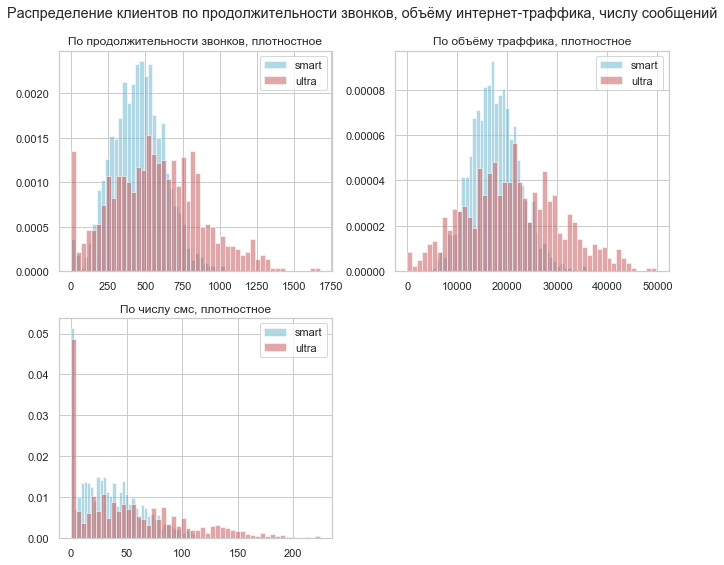

In [56]:
plt.figure(figsize=(10,8))
plt.suptitle('Распределение клиентов по продолжительности звонков, объёму интернет-траффика, числу сообщений')
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax1.set_title('По продолжительности звонков, плотностное')
ax2.set_title('По объёму траффика, плотностное')
ax3.set_title('По числу смс, плотностное')

for tariff in palette.keys():
    stat_by_calendar_month.query("tariff == @tariff")['minutes_used'].hist(ax=ax1, bins=50, label=tariff, density=True,
                                                                           color=palette[tariff], alpha=0.5)
    
    stat_by_calendar_month.query("tariff == @tariff")['mb_used'].hist(ax=ax2, bins=50, label=tariff, density=True,
                                                                           color=palette[tariff], alpha=0.5)
    
    stat_by_calendar_month.query("tariff == @tariff")['messages'].hist(ax=ax3, bins=50, label=tariff, density=True,
                                                                           color=palette[tariff], alpha=0.5)

for ax in [ax1, ax2, ax3]:
    ax.legend()

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

На гистограммах хорошо видно "расползание" и смещение гистограммы в сторону больших значений у пользователей тарифа ultra. Вариабельность среди пользователей ultra выше. Интересна доля коротких звонков, которая заметно выше, чем у пользователей smart, также как и доля сессий с небольшим объёмом интеренет траффика. 

Вообще, на гистограммах хорошо заметны отличия. Чтобы подтвердить это, воспользуюсь статистическим анализом. На гистограммах видно, что распределение данных не является нормальным. Поэтому использую **U-критерий Манна-Уитни** и **перестановочный тест**, сравнивающий "оригинальную" разность средних с набором полученных случайно. Уровень значимости приму 5%.

**H0: между выборками нет различий**

**H1: в среднем пользователи тарифа ultra дольше разговаривают, тратят больше интернет-траффика и посылают больше смс.**

$\alpha = 5 \% $ 

In [57]:
minutes_used_smart = stat_by_calendar_month.query("tariff == 'smart'")['minutes_used']
minutes_used_ultra = stat_by_calendar_month.query("tariff == 'ultra'")['minutes_used']
mb_used_smart = stat_by_calendar_month.query("tariff == 'smart'")['mb_used']
mb_used_ultra = stat_by_calendar_month.query("tariff == 'ultra'")['mb_used']
messages_smart = stat_by_calendar_month.query("tariff == 'smart'")['messages']
messages_ultra = stat_by_calendar_month.query("tariff == 'ultra'")['messages']

**Статистика по тарифам:**

In [58]:
print('Тариф smart\n')
print(f'Минуты разговора. Среднее: {minutes_used_smart.mean():.1f}, СКО: {minutes_used_smart.std():.1f}')
print(f'Итернет-траффик. Среднее: {mb_used_smart.mean():.1f}, СКО: {mb_used_smart.std():.1f}')
print(f'Число сообщений. Среднее: {messages_smart.mean():.1f}, СКО: {messages_smart.std():.1f}')

print('\nТариф ultra\n')
print(f'Минуты разговора. Среднее: {minutes_used_ultra.mean():.1f}, СКО: {minutes_used_ultra.std():.1f}')
print(f'Итернет-траффик. Среднее: {mb_used_ultra.mean():.1f}, СКО: {mb_used_ultra.std():.1f}')
print(f'Число сообщений. Среднее: {messages_ultra.mean():.1f}, СКО: {messages_ultra.std():.1f}')

Тариф smart

Минуты разговора. Среднее: 451.7, СКО: 175.6
Итернет-траффик. Среднее: 17519.2, СКО: 4891.9
Число сообщений. Среднее: 36.1, СКО: 28.6

Тариф ultra

Минуты разговора. Среднее: 573.5, СКО: 308.0
Итернет-траффик. Среднее: 21128.7, СКО: 9482.5
Число сообщений. Среднее: 53.4, СКО: 49.1


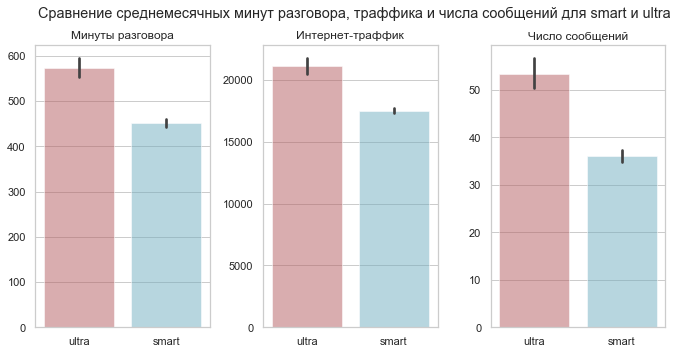

In [59]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10,5))

plt.suptitle('Сравнение среднемесячных минут разговора, траффика и числа сообщений для smart и ultra')
ax[0].set_title('Минуты разговора')
ax[1].set_title('Интернет-траффик')
ax[2].set_title('Число сообщений')

sns.barplot(y='minutes_used', data=stat_by_calendar_month, x='tariff', palette=palette, ax=ax[0], alpha=0.5)
sns.barplot(y='mb_used', data=stat_by_calendar_month, x='tariff', palette=palette, ax=ax[1], alpha=0.5)
sns.barplot(y='messages', data=stat_by_calendar_month, x='tariff', palette=palette, ax=ax[2], alpha=0.5)

for axs in ax.flatten():
    axs.set_xlabel('')
    axs.set_ylabel('')

plt.tight_layout(rect=(0, 0, 0.95, 0.95))    
plt.show()

Уже по столбчатым диаграммам с бутстрап-разбросом видно, что различия есть.

**Статистический анализ**

In [60]:
print('U-критерий Манна-Уитни, smart vs ultra')
print('Минуты разговора:', stats.mannwhitneyu(minutes_used_smart, minutes_used_ultra))
print('Итернет-траффик:', stats.mannwhitneyu(mb_used_smart, mb_used_ultra))
print('Число сообщений:', stats.mannwhitneyu(messages_smart, messages_ultra))

U-критерий Манна-Уитни, smart vs ultra
Минуты разговора: MannwhitneyuResult(statistic=595950.5, pvalue=3.63150442326733e-26)
Итернет-траффик: MannwhitneyuResult(statistic=603628.0, pvalue=2.4000101355356553e-24)
Число сообщений: MannwhitneyuResult(statistic=674876.0, pvalue=8.365410066333979e-11)


In [61]:
def permutation_test_mean(x, y, cycles=10000):
    #объём выборки и счётчик
    n, k = len(x), 0
    #преобразую series в numpy для увеличения скорости расчёта
    a=np.array(x)
    b=np.array(y)
    #объединяю выборки
    union = np.hstack((a, b))
    #оригинальная разность средних (обычная и модуль)
    diff = np.mean(a) - np.mean(b)
    abs_diff = abs(np.mean(a) - np.mean(b))
    #массив (для гистограмм), в который буду класть случайные разности средних для двустороннего теста
    abs_random_arr = np.array([])
    #цикл перемешивания и сравнения (двусторонний тест)
    for i in range (cycles):
        np.random.shuffle(union)
        abs_random_diff = abs( np.mean(union[:n])-np.mean(union[n:]) )
        k += abs_diff < abs_random_diff
        abs_random_arr = np.append(abs_random_arr, abs_random_diff)
    pvalue = k / cycles
    print(f'PermutationResult: original x_mean-y_mean = {diff:.2f}, iterations = {cycles}, pvalue = {pvalue}')

In [62]:
print('Перестановочный тест, различие средних, smart vs ultra')
print('Минуты разговора:')
permutation_test_mean(minutes_used_smart, minutes_used_ultra)
print('Итернет-траффик:')
permutation_test_mean(mb_used_smart, mb_used_ultra)
print('Число сообщений:')
permutation_test_mean(messages_smart, messages_ultra)

Перестановочный тест, различие средних, smart vs ultra
Минуты разговора:
PermutationResult: original x_mean-y_mean = -121.84, iterations = 10000, pvalue = 0.0
Итернет-траффик:
PermutationResult: original x_mean-y_mean = -3609.45, iterations = 10000, pvalue = 0.0
Число сообщений:
PermutationResult: original x_mean-y_mean = -17.36, iterations = 10000, pvalue = 0.0


<h2 style="color:DodgerBlue">Результаты анализа различий между между тарифами smart и ultra по: продолжительности звонков, числу sms и объёму интернет-траффика</h2>

Тесты показывают, что получить текущие различия в данных случайно, по сути, нельзя (p-значения критерия Манна-Уитни - это нули до 11 знака; в перестановочном тесте результат ни одной из 10000 перестановок не превысил имеющийся). На этом основании принимаю альтернативную гипотезу (со степенью уверенности, близкой к 100%, т.к. p-значения нулевые): 

**В среднем пользователи тарифа ultra дольше разговаривают, тратят больше интернет-траффика и посылают больше смс. Среднестатистический клиент ultra 2018 года в среднем говорил в месяц по телефону на 122 минуты дольше, расходовал на 3600 МБайт больше траффика и отправлял на 17 sms больше, чем пользователь тарифа smart. Среди клиентов ultra выше вариабельность всех указанных параметров. Среднеквадратичные отклонения больше, чем у пользователей smart, в 1.7 - 2 раза.**

<h2 style="color:DodgerBlue">4.2 Анализ прибыли. Отличия тарифов</h2>

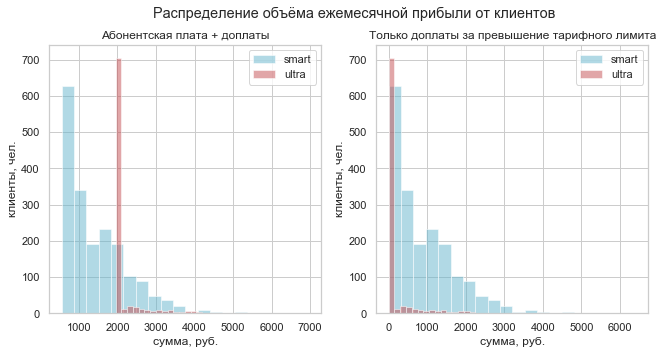

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.suptitle('Распределение объёма ежемесячной прибыли от клиентов')
ax[0].set_title('Абонентская плата + доплаты')
ax[1].set_title('Только доплаты за превышение тарифного лимита')


for tariff in palette.keys():
    stat_by_calendar_month.query("tariff == @tariff")['profit'].hist(ax=ax[0], bins=20, label=tariff,
                                                                           color=palette[tariff], alpha=0.5)
    stat_by_calendar_month.query("tariff == @tariff")['extra_charge'].hist(ax=ax[1], bins=20, label=tariff,
                                                                           color=palette[tariff], alpha=0.5)
for ax in ax.flatten():
    ax.set_xlabel('сумма, руб.')
    ax.set_ylabel('клиенты, чел.')
    ax.legend()
    
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

И снова видны сильные отличия распределений. Большинство пользователей ultra не доплачивают за превышение лимита, и это понятно: лимит гораздо выше, чем для тарифа smart. В smart довольно много доплат и превышений. Пока непонятно, от каких пользователей больше выручки, поэтому в статистических проверках буду использовать двусторонние критерии. Распределения совсем не близки к нормальным, поэтому снова применю **U-критерий Манна-Уитни** и **перестановочный тест**. Следует сделать оговорку, что в данных много повторяющихся значений (абонентская плата), поэтому, строго говоря, использование критерия Манна-Уитни здесь несколько спорно. В любом случае, результат будет проверен в перестановочном тесте.

**H0: Между выборками ежемесячной прибыли от клиентов smart и ultra нет различий**

**H1: Выборки различаются. Клиенты одного из тарифов в среднем приносят компании больше прибыли**

$\alpha = 5 \% $ 

In [64]:
profit_smart = stat_by_calendar_month.query("tariff == 'smart'")['profit']
profit_ultra = stat_by_calendar_month.query("tariff == 'ultra'")['profit']
extra_smart = stat_by_calendar_month.query("tariff == 'smart'")['extra_charge']
extra_ultra = stat_by_calendar_month.query("tariff == 'ultra'")['extra_charge']

**Статистика по тарифам:**

In [65]:
print('Тариф smart\n')
print(f'Абонентская плата + доплаты. Среднее: {profit_smart.mean():.1f}, СКО: {profit_smart.std():.1f}')
print(f'Только доплаты за превышение тарифного лимита. Среднее: {extra_smart.mean():.1f}, СКО: {extra_smart.std():.1f}')

print('\nТариф ultra\n')
print(f'Абонентская плата + доплаты. Среднее: {profit_ultra.mean():.1f}, СКО: {profit_ultra.std():.1f}')
print(f'Только доплаты за превышение тарифного лимита. Среднее: {extra_ultra.mean():.1f}, СКО: {extra_ultra.std():.1f}')

Тариф smart

Абонентская плата + доплаты. Среднее: 1414.3, СКО: 842.4
Только доплаты за превышение тарифного лимита. Среднее: 864.3, СКО: 842.4

Тариф ultra

Абонентская плата + доплаты. Среднее: 2093.2, СКО: 413.6
Только доплаты за превышение тарифного лимита. Среднее: 143.2, СКО: 413.6


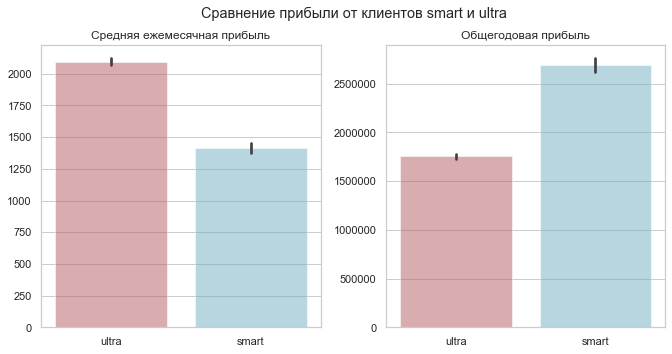

In [66]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

plt.suptitle('Сравнение прибыли от клиентов smart и ultra')
ax[0].set_title('Средняя ежемесячная прибыль')
ax[1].set_title('Общегодовая прибыль')

sns.barplot(y='profit', data=stat_by_calendar_month, x='tariff', palette=palette, ax=ax[0], alpha=0.5)
sns.barplot(y='profit', data=stat_by_calendar_month, x='tariff', palette=palette, ax=ax[1], alpha=0.5, estimator=np.sum)

for axs in ax.flatten():
    axs.set_xlabel('')
    axs.set_ylabel('')

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

А вот из диаграмм и цифр видно преимущество ultra в среднемесячной прибыли и smart - в общегодовой. И видны значимые различия по бутстрап-разбросу.

**Статистический анализ**

In [67]:
print('U-критерий Манна-Уитни, smart vs ultra')
print('Абонентская плата + доплаты:', stats.mannwhitneyu(profit_smart, profit_ultra))
print('Только доплаты за превышение тарифного лимита:', stats.mannwhitneyu(extra_smart, extra_ultra))

U-критерий Манна-Уитни, smart vs ultra
Абонентская плата + доплаты: MannwhitneyuResult(statistic=340114.0, pvalue=9.631137956061817e-130)
Только доплаты за превышение тарифного лимита: MannwhitneyuResult(statistic=247052.5, pvalue=2.7804044369982433e-192)


In [68]:
print('Перестановочный тест, различие средних, smart vs ultra')
print('\nАбонентская плата + доплаты:')
permutation_test_mean(profit_smart, profit_ultra)
print('\nТолько доплаты за превышение тарифного лимита:')
permutation_test_mean(extra_smart, extra_ultra)

Перестановочный тест, различие средних, smart vs ultra

Абонентская плата + доплаты:
PermutationResult: original x_mean-y_mean = -678.94, iterations = 10000, pvalue = 0.0

Только доплаты за превышение тарифного лимита:
PermutationResult: original x_mean-y_mean = 721.06, iterations = 10000, pvalue = 0.0


Тесты вновь ожидаемо показывают, что получить существующие различия в данных случайно, по сути, нельзя (p-значения критерия Манна-Уитни - это нули до 130 знака; в перестановочном тесте результат ни одной из 10000 перестановок не превысил имеющийся). На этом основании отбрасываю нулевую и принимаю альтернативную гипотезу: 


**H1: Выборки различаются. Клиенты одного из тарифов в среднем приносят компании больше прибыли**

<h2 style="color:DodgerBlue">Результаты сравнения среднемесячной прибыли по тарифам smart и ultra</h2>

**Выборки статистически значимо различаются, p-значения нулевые. Клиенты одного из тарифов в среднем приносят компании больше прибыли. Из анализа средних хорошо видно, что в среднем больше прибыли в месяц приносит клиент тарифа ultra**: 2093.2 против 1414.3 руб. (почти в полтора раза). При этом клиенты ultra доплачивают сверх лимита в среднем в 6 раз меньше клиентов smart (143.2 против 864.3 руб.). Это видно и из показателей вариабельности прибыли: для ultra 413.6 руб, для smart 842.4 руб.

Получается, клиенты ultra в среднем более предсказуемы и более прибыльны, чем smart. Однако, часть клиентов smart платит больше, чем ultra, из-за превышений лимита. И их больше в 2.3 раза, чем клиентов ultra. Поэтому имеет место следующая статистика общегодовой прибыли:

In [69]:
print('Общегодовая прибыль с тарифа smart:', profit_smart.sum())
print('Общегодовая прибыль с тарифа ultra:', profit_ultra.sum())
print(f'Smart принёс за год в {profit_smart.sum()/profit_ultra.sum():.2f} раза больше прибыли, чем ultra')
print(f"""Но клиент ultra за месяц в среднем приносит в {profit_ultra.mean()/profit_smart.mean():.2f} раз больше прибыли, 
чем клиент smart""")
smart_clients_count = len(stat_by_calendar_month.query("tariff == 'smart'").groupby('user_id'))
ultra_clients_count = len(stat_by_calendar_month.query("tariff == 'ultra'").groupby('user_id'))
print(f'В выборке клиентов smart в {smart_clients_count/ultra_clients_count:.2f} раза больше, чем клиентов ultra')

Общегодовая прибыль с тарифа smart: 2688498
Общегодовая прибыль с тарифа ultra: 1754100
Smart принёс за год в 1.53 раза больше прибыли, чем ultra
Но клиент ultra за месяц в среднем приносит в 1.48 раз больше прибыли, 
чем клиент smart
В выборке клиентов smart в 2.33 раза больше, чем клиентов ultra


<h2 style="color:DodgerBlue">4.3 Отличия Москвы от других городов по среднемесячной прибыли с клиентов</h2>

Интересно оценить, отличается ли клиент из Москвы от клиентов из других городов. Изучу отличия по прибыли.

In [70]:
moscow_clients_count = len(stat_by_calendar_month.query("city == 'Москва'").groupby('user_id'))
moscow_smart_clients_count = len(stat_by_calendar_month.query("city == 'Москва' and tariff == 'smart'").groupby('user_id'))
moscow_ultra_clients_count = len(stat_by_calendar_month.query("city == 'Москва' and tariff == 'ultra'").groupby('user_id'))

other_clients_count = len(stat_by_calendar_month.query("city != 'Москва'").groupby('user_id'))


profit_moscow = stat_by_calendar_month.query("city == 'Москва'")['profit']
profit_moscow_smart = stat_by_calendar_month.query("city == 'Москва' and tariff == 'smart'")['profit']
profit_moscow_ultra = stat_by_calendar_month.query("city == 'Москва' and tariff == 'ultra'")['profit']

profit_other = stat_by_calendar_month.query("city != 'Москва'")['profit']
profit_other_smart = stat_by_calendar_month.query("city != 'Москва' and tariff == 'smart'")['profit']
profit_other_ultra = stat_by_calendar_month.query("city != 'Москва' and tariff == 'ultra'")['profit']

print('Записей по месяцам для Москвы:', profit_moscow.count())
print('Записей по месяцам для других городов:', profit_other.count())
print(f'Клиентов из Москвы: {moscow_clients_count}, из них {moscow_smart_clients_count} - smart, {moscow_ultra_clients_count} - ultra')
print('Клиентов из других городов:', other_clients_count)
print(f'Записей для ultra по Москве:', profit_moscow_ultra.count())
print(f'Записей для smart по Москве:', profit_moscow_smart.count())

Записей по месяцам для Москвы: 517
Записей по месяцам для других городов: 2222
Клиентов из Москвы: 94, из них 62 - smart, 32 - ultra
Клиентов из других городов: 372
Записей для ultra по Москве: 194
Записей для smart по Москве: 323


Клиентов ultra из Москвы немного, 32. Но записей, в принципе, почти 200. Критерий Манна-Уитни подходит для анализа небольших выборок. В любом случае, работаю с имеющимся материалом. Посмотрим, какие отличия по цифрам. 

**Статистика по городам и тарифам:**

In [71]:
print('Среднемесячная прибыль. Отличия Москвы от других городов\n')
print('smart+ultra, разница средних:', profit_moscow.mean() - profit_other.mean())
print('ultra, разница средних:', profit_moscow_ultra.mean() - profit_other_ultra.mean())
print('smart, разница средних:', profit_moscow_smart.mean() - profit_other_smart.mean())

print('\nСКО среднемесячной прибыли. Отличия Москвы от других городов\n')
print('smart+ultra, разница средних:', profit_moscow.std() - profit_other.std())
print('ultra, разница средних:', profit_moscow_ultra.std() - profit_other_ultra.std())
print('smart, разница средних:', profit_moscow_smart.std() - profit_other_smart.std())

Среднемесячная прибыль. Отличия Москвы от других городов

smart+ultra, разница средних: 25.033341632035672
ultra, разница средних: 2.8142408913363397
smart, разница средних: -53.119110682095425

СКО среднемесячной прибыли. Отличия Москвы от других городов

smart+ultra, разница средних: -75.65846566332812
ultra, разница средних: -44.7503491004299
smart, разница средних: -86.32520541796839


Вариабельность в других городах выше, чем в Москве. Это понятно, там больше клиентов и они из разных городов. Можно оценить статистическую значимость в ANOVA, но, на мой взгляд, это находится за рамками задачи. Думаю, достаточно отметить, что наблюдается логичная картина.

Разница средних для ultra практически нулевая. Думаю, нет смысла искать там статистическую разницу: среднестатистический клиент ultra в Москве приносит столько же прибыли, как в других городах. 

Можно оценить, какой размер эффекта удастся обнаружить для тарифа smart с объёмом записей по Москве 323, воспользовавшись оценкой мощности t-теста. В данном случае размер эффекта будет показывать отношение разности средних к СКО. Посокольку t-тест - аналог перестановочного для сравнения средних, можно примерно понять возможности перестановочного теста. Примем alpha = 0.05 (уровень значимости), power = 0.95 (95% вероятность обнаружить данный размер эффекта, если он неслучаен)

**Оценка эффективности предстоящего статистического анализа**

In [72]:
effect_size = None #(его определим)
alpha = 0.05 # significance level
power = 0.95
nobs1 = profit_moscow_smart.count()

power_analysis = statsmodels.stats.power.TTestIndPower()
x_powertest = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha,
                                        nobs1 = nobs1)

print(f'Размер эффекта при alpha {alpha}, мощности {power} и размере выборки {nobs1}: {x_powertest:.2f}')

Размер эффекта при alpha 0.05, мощности 0.95 и размере выборки 323: 0.28


Согласно Sawilowsky, S (2009). "New effect size rules of thumb" этот размер эффекта чуть более, чем малый, что вполне неплохо. Т.е. можно найти различия в пределах 0.28 от СКО в выборке smart.

In [73]:
print(f'СКО среднемесячной прибыли по тарифу smart в Москве: {profit_moscow_smart.std():.1f}')
print(f"""
В 95% случаев для такого СКО при объёме выборки {nobs1} и alpha={alpha} 
перестановочный тест может выявить неслучайность различий средних {x_powertest*profit_moscow_smart.std():.1f} и более""")
print(f'\nSmart, текущая разница средних: {profit_moscow_smart.mean() - profit_other_smart.mean():.1f}')

СКО среднемесячной прибыли по тарифу smart в Москве: 770.1

В 95% случаев для такого СКО при объёме выборки 323 и alpha=0.05 
перестановочный тест может выявить неслучайность различий средних 218.8 и более

Smart, текущая разница средних: -53.1


То есть, на самом деле, статистически значимого эффекта, скорее всего, найдено не будет при таких отличиях и таких объёмах выборок, как заданная. В любом случае, несложно провести указанные тесты. Сначала изучу гистограммы для Москвы и прочих городов:

**Анализ распределений**

In [74]:
msc_other_list=[(profit_moscow, profit_other), 
                (profit_moscow_smart, profit_other_smart), 
                (profit_moscow_ultra, profit_other_ultra)]
titles_list = ['оба тарифа', 'smart', 'ultra']

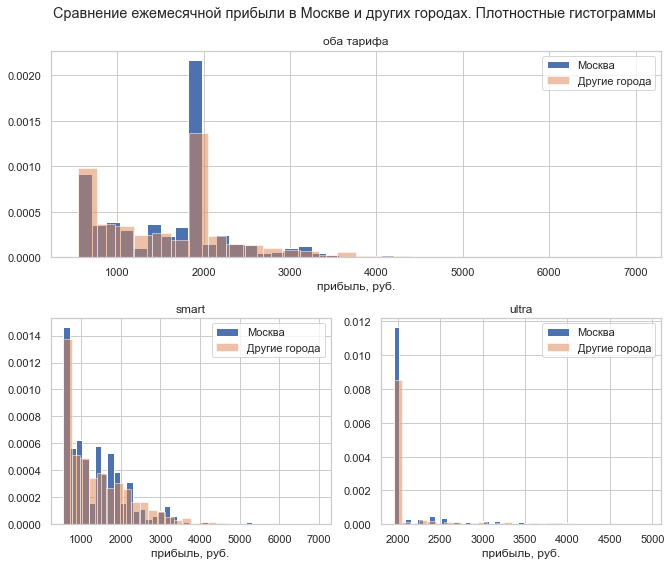

In [75]:
plt.figure(figsize=(10,8))

ax1=plt.subplot(211)
ax2=plt.subplot(223)
ax3=plt.subplot(224)
ax = [ax1, ax2, ax3]

i = 0

plt.suptitle('Сравнение ежемесячной прибыли в Москве и других городах. Плотностные гистограммы')
for msc, othr in msc_other_list:
    ax[i].set_title(titles_list[i])
    ax[i].hist(msc, bins=30, density=True, label='Москва')
    ax[i].hist(othr, bins=30, density=True, alpha=0.5, label='Другие города')
    ax[i].legend()
    ax[i].set_xlabel('прибыль, руб.')
    i += 1

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

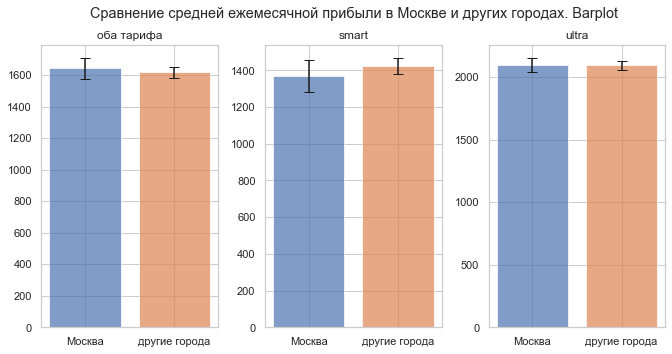

In [76]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10,5))
i = 0
plt.suptitle('Сравнение средней ежемесячной прибыли в Москве и других городах. Barplot')
for msc, othr in msc_other_list:
    ax[i].set_title(titles_list[i])
    ax[i].bar('Москва', msc.mean(), width = 0.8, alpha=0.7,
              yerr=2*msc.std()/np.sqrt(len(msc)), capsize=5)
    ax[i].bar('другие города', othr.mean(), width = 0.8, alpha=0.7, 
              yerr=2*othr.std()/np.sqrt(len(othr)), capsize=5)
    ax[i].set_xlabel('')
    i += 1
    
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

Гистограммы и barplot показывают картину, аналогичную числам. Картины очень похожи. Похоже, значимых различий при имеющихся объёмах выборок найти не получится.

Тем не менее, покажу это, выполнив статистический тест.

**Статистический анализ**

**H0: Между выборками с данными о ежемесячной прибыли от клиентов Москвы и других городов нет различий. Средняя прибыль от клиентов из Москвы и других городов не отличается.**

**H1: Выборки различаются. Клиенты из Москвы в среднем приносят иную прибыль, чем клиенты из других городов.**

$\alpha = 5 \% $ 

In [77]:
print('Перестановочный тест, различие средних, Москва vs другие города')
print('smart+ultra:')
permutation_test_mean(profit_moscow, profit_other)
print('smart:')
permutation_test_mean(profit_moscow_smart, profit_other_smart)
print('ultra:')
permutation_test_mean(profit_moscow_ultra, profit_other_ultra)

Перестановочный тест, различие средних, Москва vs другие города
smart+ultra:
PermutationResult: original x_mean-y_mean = 25.03, iterations = 10000, pvalue = 0.5213
smart:
PermutationResult: original x_mean-y_mean = -53.12, iterations = 10000, pvalue = 0.3031
ultra:
PermutationResult: original x_mean-y_mean = 2.81, iterations = 10000, pvalue = 0.9276


In [78]:
print('Критерий Манна-Уитни, Москва vs другие города')
print('smart+ultra:', stats.mannwhitneyu(profit_moscow, profit_other))
print('smart:', stats.mannwhitneyu(profit_moscow_smart, profit_other_smart))
print('ultra:', stats.mannwhitneyu(profit_moscow_ultra, profit_other_ultra))

Критерий Манна-Уитни, Москва vs другие города
smart+ultra: MannwhitneyuResult(statistic=557260.5, pvalue=0.14239837080130424)
smart: MannwhitneyuResult(statistic=249168.0, pvalue=0.2633215999814378)
ultra: MannwhitneyuResult(statistic=60410.0, pvalue=0.13610510207465132)


Интересно сравнить результат перестановочного теста с t-тестом. Хотя формально t-тест для таких распределений не используется:

In [79]:

print('t-тест, различие средних, Москва vs другие города')
print('smart+ultra:', stats.ttest_ind(profit_moscow, profit_other))
print('smart:', stats.ttest_ind(profit_moscow_smart, profit_other_smart))
print('ultra:', stats.ttest_ind(profit_moscow_ultra, profit_other_ultra))


t-тест, различие средних, Москва vs другие города
smart+ultra: Ttest_indResult(statistic=0.6394320054930425, pvalue=0.5225954464506865)
smart: Ttest_indResult(statistic=-1.032492619612985, pvalue=0.30197287575731224)
ultra: Ttest_indResult(statistic=0.08304059410852824, pvalue=0.9338391402404161)


И результат почти полностью аналогичен перестановочному тесту по pvalue.

<h2 style="color:DodgerBlue">Результаты сравнительного анализа Москвы с другими городами по среднемесячной прибыли с клиентов</h2>

По полученным результатам для принятого уровнем значимости (не хуже 5%) нет оснований отвергнуть нулевую гипотезу. Т.е. **среднемесячная прибыль от клиентов из Москвы и из других городов не различается**. Между выборками статистически значимых отличий нет. Результат справедлив как для тарифов по отдельности, так и для объединённой выборки.

Критерий Манна-Уитни показал самые низкие значения p, хотя все они превышают 5%. Это можно объяснить разницей статистик критерия для перестановочного теста и рангового теста. Вообще, есть сомнения в том, что Манн-Уитни подходит для тарифов, т.к. много совпадающих значений из-за наличия абонентской платы. Однако результат подкреплён перестановочным тестом.

В цифрах некоторые отличия есть. Чтобы оценить, случайны они или нет, нужно увеличить объём выборки. Стоит предупредить, что есть опасность получить "эффект прочёсывания данных", т.е. найти отличия там, где их в действительности нет. 

Максимальная разница среднемесячной прибыли между Москвой и другими городами - по тарифу смарт (в Москве на 53 руб меньше). Чтобы статистический тест был чувствителен к такой разнице (мог выявить, что она неслучайна), нужен объём выборки не менее:

In [80]:
effect_size = abs((profit_moscow_smart.mean() - profit_other_smart.mean()) / profit_moscow_smart.std())
alpha = 0.05 # significance level
power = 0.95
nobs1 = None #(его определим)
power_analysis = statsmodels.stats.power.TTestIndPower()
x_powertest = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha,
                                        nobs1 = nobs1)
print(f"""Размер выборки, необходимой для выявления отличия средних {(profit_moscow_smart.mean() - profit_other_smart.mean()):.1f} 
при СКО {profit_moscow_smart.std():.1f} 
alpha {alpha} 
мощности {power}: 
{x_powertest:.1f}""")

Размер выборки, необходимой для выявления отличия средних -53.1 
при СКО 770.1 
alpha 0.05 
мощности 0.95: 
5463.5


Опираясь на имеющуюся выборку, это около 1000 клиентов только по Москве

<h1 style="color:SteelBlue; font-size:200%">Результаты сравнительного анализа доходности тарифов сотовой связи </h1>

С высокой степенью уверенности (p-значения тестов практически нулевые, десятки нулей после запятой; т.е. получить такие же результаты случайно почти невозможно) можно утверждать:

- **В среднем пользователи тарифа ultra дольше разговаривают, тратят больше интернет-траффика и посылают больше SMS.** Среднестатистический клиент ultra 2018 года в среднем говорил в месяц по телефону на 122 минуты дольше, расходовал на 3600 МБайт больше траффика и отправлял на 17 sms больше, чем пользователь тарифа smart. Среди клиентов ultra выше вариабельность всех указанных параметров. Среднеквадратичные отклонения больше, чем у пользователей smart, в 1.7 - 2 раза.


- **Клиенты ultra в среднем более прибыльны** (2093.2 руб. в месяц с клиента ultra, против 1414.3 руб. со smart) **и более предсказуемы** (СКО прибыли 143.2 руб у ультра и 864.3 руб. у смарт). Клиент ultra за месяц в среднем приносит в 1.48 раз больше прибыли, чем клиент smart. Однако, часть клиентов smart платит больше, чем ultra, из-за превышений лимита. И в выборке клиентов smart больше в 2.3 раза, чем клиентов ultra. Поэтому **по выборке в целом smart принёс за год в 1.53 раза больше прибыли, чем ultra.**

Важно отметить в этой связи, что относительно smart *в Петербурге, по сравнению с другими городами из ТОПа пользователей, слабо представлен тариф ultra.* Это видно на гистограммах (более чем в 3 раза меньше пользователей ultra по отношению к смарт; в других городах примерно в 2 раза). *Возможно, было бы полезно продвигать ultra в Петербурге более активно.* Очевидно, что при равном числе пользователей тариф ultra в среднем приносит прибыль выше.

Ни статистический, ни исследовательский (по графикам) анализ **не выявили отличий прибыли от московских и не-московских клиентов.** По цифрам некоторые отличия есть, но аналогичные получались в перестановочном тесте в 30 и более процентах случаев.